Hierarchical Bayes and Gibbs Sampling Example: Teenagers' Heights
=======================================================


This notebook will take you though an example of the construction of a Bayesian hierarchical model for the evolution of the heights of a population of teenagers with age. We will then sample from the posterior distribution for some mock data using Gibbs sampling.

First we will build a generative model for mock height measurements. Then we will build a Bayesian hierarchical model and write down the posterior probability distribution. Finally, we will use Gibbs sampling to reclaim the input parameters of our generative model.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import invgamma
%matplotlib inline

A generative model for measurements of teenagers' heights
----------------------------------------------------------------------

For each individual we will model their height, $y$ as a linear function of their age, $x$. For a series of measurements $i$, with uncertainties $\sigma_i$, the relationship is

$y_i = mx_i + c + \sigma_i$.


We will further assume that for each individual, $j$, the parameters of the relationship, $m_j$ and $c_j$ are drawn from Gaussian distributions such that

$m_j \sim N(\mu_m, \sigma_m^2)$

$c_j \sim N(\mu_c, \sigma_c^2)$.

We can set up some code to generate some mock data as follows

In [2]:
# Set the population parameters
mu_c = 0.
sig_c = 10.
mu_m = 9.
sig_m = 1.

# Set the range of ages for which we have data
x_range = (10., 18.)

# Set the minimum error for each measurement.
error_floor = 5.

def generate_pop_params(n=500):
    ints = sig_c*np.random.randn(n) + mu_c
    grads = sig_m*np.random.randn(n) + mu_m
    population = []
    
    for i in range(n):
        N = np.random.randint(2, high=5)

        x_vals = (x_range[1] - x_range[0])*np.random.rand(N) + x_range[0]
        y_vals = grads[i]*x_vals + ints[i]
        y_sigs = error_floor + error_floor*np.random.randn(N)**2
        y_vals += y_sigs*np.random.randn(N)
        population.append(np.c_[x_vals, y_vals, y_sigs])


    return ints, grads, population

In [3]:
ints, grads, population = generate_pop_params()

The distribution of population parameters looks like this:

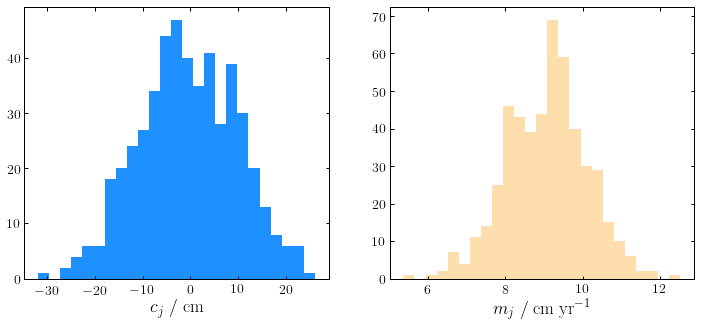

In [4]:
plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.hist(ints, color="dodgerblue", bins=25)
ax2.hist(grads, color="navajowhite", bins=25)
ax1.set_xlabel("$c_j\\ /\\ \\mathrm{cm}$")
ax2.set_xlabel("$m_j\\ /\\ \\mathrm{cm\\ yr^{-1}}$")
plt.show()

The relationships for a few example individuals look like this (the solid lines are the input relationships, the points show the samples we generated):

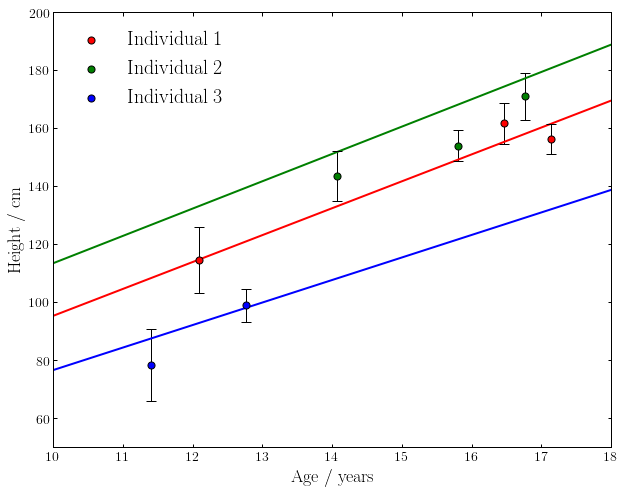

In [5]:
plt.figure(figsize=(10, 8))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")

x = np.arange(10, 18, 0.01)

colors = ["red", "green", "blue"]

for i in range(3):
    data = population[i]
    plt.plot(x, grads[i]*x + ints[i], color=colors[i])
    plt.errorbar(data[:,0], data[:,1], data[:,2], ls="", capsize=5, color="black", lw=1)
    plt.scatter(data[:,0], data[:,1], color=colors[i], lw=1, edgecolor="black", zorder=10,
                s=50, label="$\\mathrm{Individual\\ " + str(i+1) + "}$")

plt.legend(frameon=False, fontsize=20)
plt.show()

A classical approach: fitting individual objects using a maximum likelihood method
-------------------------------------------------------------------------------------------------

Now that we have our generative model, and resulting mock data samples, let's try a classical approach by fitting a straight line model to each individual using a maximum likelihood (chi-squared) method. Numpy provides a function to do this in a single line of code, the resulting best fits are shown in gray:

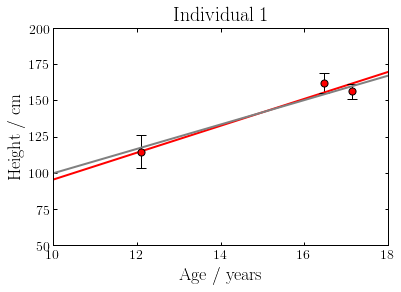

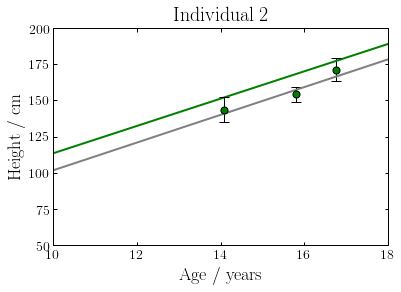

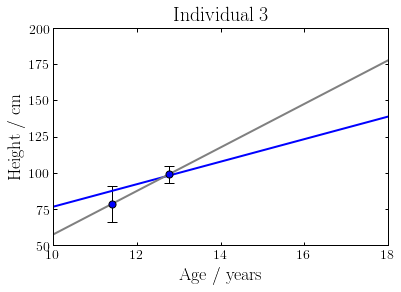

In [6]:
for i in range(3):
    plt.figure(figsize=(6, 4))
    plt.xlim(10, 18)
    plt.ylim(50, 200)
    plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
    plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
    plt.title("$\\mathrm{Individual\\ " + str(i+1) + "}$", size=20)
    
    data = population[i]
    plt.plot(x, grads[i]*x + ints[i], color=colors[i])
    plt.errorbar(data[:,0], data[:,1], data[:,2], ls="", capsize=5, color="black", lw=1)
    plt.scatter(data[:,0], data[:,1], color=colors[i], lw=1, edgecolor="black", zorder=10, s=50)
    param = np.polyfit(data[:,0], data[:,1], 1, w=1/data[:,2])
    plt.plot(x, param[0]*x + param[1], color="gray")

    plt.show()



As you can see the results aren't always particularly close to the input relationships. This is by design: some of the individuals only have two noisy datapoints and therefore their growth rates are poorly constrained. Let's compare the input and recovered relationships for the whole population:

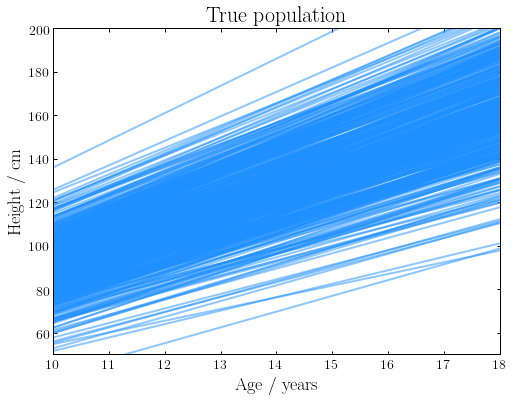

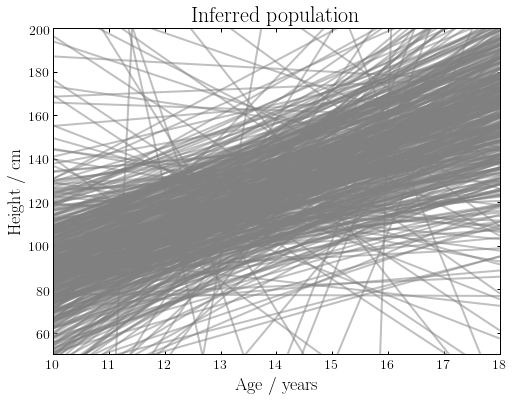

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
plt.title("$\\mathrm{True\\ population}$", fontsize=22)

for i in range(500):
    data = population[i]
    plt.plot(x, grads[i]*x + ints[i], color="dodgerblue", alpha=0.5)

plt.show()

plt.figure(figsize=(8, 6))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
plt.title("$\\mathrm{Inferred\\ population}$", fontsize=22)

for i in range(500):
    data = population[i]
    param = np.polyfit(data[:,0], data[:,1], 1, w=1/data[:,2])
    plt.plot(x, param[0]*x + param[1], color="gray", alpha=0.5)

plt.show()

You can see that for the majority of objects the true distribution is relatively well recovered. However, for a significant fraction of the population, the data is very poorly constraining, resulting in individuals for which the inferred relationships look nothing like the input population.

However, we're not really making use of all the information we have for these individuals. Whilst we know relatively little about their individual growth rates, we know that they are members of a population with similar properties. In this case we can "borrow" constraining power from the population as a whole in order to better constrain the growth rates of individuals.

Setting up our Bayesian hierarchical model
--------------------------------------------------

We can do this by the use of a Bayesian hierarchical model. The idea here is to use the population statistics (the two Gaussian distributions for $m_j$ and $c_j$) as priors to apply to the $m$ and $c$ values for individual growth rates. We will constrain the population parameters $\mu_m, \mu_c, \sigma_m$ and $\sigma_c$ using our whole dataset, as well as constraining each of the $\{m_j\}$ and $\{c_j\}$.

We start by writing down the quantity we want to know, the posterior distribution: the probability of a set of model parameters given our observations $\{y_i\}_j$

$P(\mu_m,\ \mu_c,\ \sigma_m,\ \sigma_c,\ \{m_j\},\ \{c_j\}\ \ |\ \ \{y_i\}_j)$.

For readability let's compress this to:

$P(\mu,\ \sigma,\ m,\ c\ \ |\ \ y)$.

Our aim now is to break this down into a series of simpler functions which we can write down expressions for. 

To do this, we're going to need some standard results from probability theory:

> Firstly, the product rule states that
>
> $P(x,\ y) = P(x\ \ |\ \ y)\ P(y)$.
>
> From this we can directly obtain Bayes theorem by
>
> $P(y,\ x) = P(x,\ y)$
>
> $P(y\ \ |\ \ x)\ \ P(x) = P(x\ \ |\ \ y)\ \ P(y)$
>
> $P(y\ \ |\ \ x) = \dfrac{P(x\ \ |\ \ y)\ \ P(y)}{P(x)}$

We can use Bayes theorem to flip and split up our distribution. We're not particularly interested in the normalisation, and our $\{y_i\}_j$ are fixed, so

$P(\mu,\ \sigma,\ m,\ c\ \ |\ \ y)\ \propto\ P(y\ \ |\ \ \mu,\ \sigma,\ m,\ c)\ P(\mu,\ \sigma,\ m,\ c)$.

It is helpful at this stage to introduce model parameters which correspond to the true values of $\{y_i\}_j$, unperturbed by noise. We will denote these collectively as $\{\widehat{y}_i\}_j$, or for brevity, $\widehat{y}$, and marginalise over them by integrating. Our posterior now looks like

$\int P(y,\ \widehat{y}\ \ |\ \ \mu,\ \sigma,\ m,\ c)\ \ P(\mu,\ \sigma,\ m,\ c)\ \mathrm{d}\widehat{y}$.

We can use this to split the first term into contributions from our uncertainties and our model by using the product rule

$\int P(y\ \ |\ \ \widehat{y},\ \mu,\ \sigma,\ m,\ c)\ \ P(\widehat{y}\ \ |\ \ \mu,\ \sigma,\ m,\ c)\ \ P(\mu,\ \sigma,\ m,\ c)\ \mathrm{d}\widehat{y}$.

The dependency of the first term on the parameters $\mu, \sigma, m, c$ is encapsulated within $\widehat{y}$, so we can remove these parameters from this term.

$\int P(y\ \ |\ \ \widehat{y})\ \ P(\widehat{y}\ \ |\ \ \mu,\ \sigma,\ m,\ c)\ \ P(\mu,\ \sigma,\ m,\ c)\ \mathrm{d}\widehat{y}$.

We can now split the third term up again using the product rule

$\int P(y\ \ |\ \ \widehat{y})\ \ P(\widehat{y}\ \ |\ \ \mu,\ \sigma,\ m,\ c)\ \ P(m,\ c\ \ |\ \mu,\ \sigma)\ \ P(\mu,\ \sigma)\ \mathrm{d}\widehat{y}$.

Finally we can perform the integral to marginalise over our $\widehat{y}$, the second term is a delta function, $\delta (\widehat{y} -mx - c)$ which makes this very simple. Our final answer is

$P(\mu,\ \sigma,\ m,\ c\ \ |\ \ y)\ \propto\ P(y\ \ |\ \ mx + c)\ \ P(m,\ c\ \ |\ \ \mu,\ \sigma)\ \ P(\mu,\ \sigma)$.

The three terms are: firstly the likelihoods for individual objects, secondly the distribution of the parameters of individual relationships within the population and thirdly the hyperpriors on our population distributions.

Now we can write down expressions for each of these three terms for a population with $N_j$ individuals with $N_i$ measurements each. Firstly, the product of likelihoods for individual objects

$P(y\ \ |\ \ mx + c)\ \ = \ \ \prod_j \ \dfrac{1}{\Big((2\pi)^\frac{N_i}{2}\ \prod_i\sigma_{ij}\Big)} \ \mathrm{exp}\bigg(-\sum_i \dfrac{(y_{ij} - m_j x_{ij} - c_j)^2}{2\sigma_{ij}^2}\bigg)$.

Secondly, the probability distributions for each of our $m_j$ and $c_j$

$P(m,\ c\ \ |\ \mu,\ \sigma)\ \ = \ \ \dfrac{1}{(2\pi \sigma_{c} \sigma_{m})^{N_j}} \prod_j \mathrm{exp}\bigg(- \dfrac{(m_j - \mu_m)^2}{2\sigma_{m}^2}\bigg)\ \prod_j \mathrm{exp}\bigg(- \dfrac{(c_j - \mu_c)^2}{2\sigma_{c}^2}\bigg)$.

FInally we need to choose a prior on our hyperparameters, $\mu_m,\ \mu_c,\ \sigma_m$ and $\sigma_c$. We will use the Jeffreys prior, which for this case is uniform in the means and proportional to one over the standard deviation in each case

$P(\mu,\ \sigma) = \dfrac{1}{\sigma_m \sigma_c}$

Therefore, dropping the constant prefactors ($2\pi$, $N_j$ and the product over $\sigma_{ij}$), our full posterior distribution is 

$P(\mu,\ \sigma,\ m,\ c\ \ |\ \ y)\ \propto\ \dfrac{1}{(\sigma_m \sigma_c)^{N_j+1}} \prod_j \mathrm{exp}\bigg(-\sum_i \dfrac{(y_{ij} - m_j x_{ij} - c_j)^2}{2\sigma_{ij}^2}\bigg) \prod_j \mathrm{exp}\bigg(- \dfrac{(m_j - \mu_m)^2}{2\sigma_{m}^2}\bigg)\ \prod_j \mathrm{exp}\bigg(- \dfrac{(c_j - \mu_c)^2}{2\sigma_{c}^2}\bigg)$

which can be written as 

$P(\mu,\ \sigma,\ m,\ c\ \ |\ \ y)\ \propto\ \dfrac{1}{(\sigma_m \sigma_c)^{N_j+1}} \prod_j \mathrm{exp}\Bigg(-\sum_i \bigg(\dfrac{(y_{ij} - m_j x_{ij} - c_j)^2}{2\sigma_{ij}^2}\bigg)\ - \dfrac{(m_j - \mu_m)^2}{2\sigma_{m}^2}\ - \dfrac{(c_j - \mu_c)^2}{2\sigma_{c}^2}\Bigg)$

We can sample directly from this posterior distribution, however for the population of $N_j = 500$ individuals which we set up earlier, this posterior distribution has 1004 free parameters. This isn't going to be tractable with a traditional MCMC or nested sampling approach, we need to use Gibbs sampling.

Obtaining the full posterior distribution with Gibbs sampling
----------------------------------------------------------------------

Gibbs sampling allows us to sample the full posterior by sampling from the conditional distribution for each parameter in turn, i.e. $P(\theta_1\ |\ \theta_2 ... \theta_N, \mathrm{data})$ then $P(\theta_2\ |\ \theta_1,\ \theta_3, ... \theta_N, \mathrm{data})$ etc. The easiest way to do this is to rearrange the posterior into a series of standard functions in each of our parameters from which we can directly sample without rejecting any points.

We can rearrange our posterior by expanding the brackets and then completing the square

$P(\mu,\ \sigma,\ m,\ c\ \ |\ \ y)\ \propto\ \dfrac{1}{(\sigma_m \sigma_c)^{N_j+1}} \prod_j \mathrm{exp}\Bigg(
-\sum_i \bigg(\dfrac{y_{ij}^2 + m_j^2 x_{ij}^2 + c_j^2 + 2 m_j c_j x_{ij} - 2 c_j y_{ij} - 2 m_j x_{ij} y_{ij}}{2\sigma_{ij}^2}\bigg) - \dfrac{m_j^2 + \mu_m^2 - 2\mu_m m_j}{2\sigma_{m}^2} - \dfrac{c_j^2 + \mu_c^2 - 2\mu_c c_j}{2\sigma_{c}^2}\Bigg)$

The argument of the exponential can be further expanded to give

$P(\mu,\ \sigma,\ m,\ c\ \ |\ \ y)\ \propto\ \dfrac{1}{(\sigma_m \sigma_c)^{N_j+1}} \prod_j \mathrm{exp}\Bigg(- \dfrac{1}{2} \sum_i \bigg( \dfrac{ y_{ij}^2}{\sigma_{ij}^2}\bigg) - \dfrac{m_j^2}{2} \sum_i \bigg(\dfrac{x_{ij}^2}{\sigma_{ij}^2}\bigg) - \dfrac{c_j^2}{2} \sum_i \bigg(\dfrac{1}{\sigma_{ij}^2}\bigg) - m_j c_j \sum_i \bigg(\dfrac{x_{ij}}{\sigma_{ij}^2}\bigg) + c_j \sum_i \bigg(\dfrac{y_{ij}}{\sigma_{ij}^2}\bigg) + m_j \sum_i \bigg(\dfrac{x_{ij} y_{ij}}{\sigma_{ij}^2}\bigg) - \dfrac{m_j^2}{2\sigma_{m}^2} - \dfrac{\mu_m^2}{2\sigma_{m}^2} + \dfrac{\mu_m m_j}{\sigma_{m}^2} - \dfrac{c_j^2}{2\sigma_{c}^2} - \dfrac{\mu_c^2}{2\sigma_{c}^2} + \dfrac{\mu_c c_j}{\sigma_{c}^2}\Bigg)$

Having expanded this (awful) expression, we can figure out our conditional distributions. We only need proportionality rather than the correct normalisation, so we can throw away any terms which don't include the parameter we're interested in. We need to do separate calculations for six different cases, $\mu_m,\ \mu_c,\ \sigma_m,\ \sigma_c,\ m_j$ and $c_j$.



---

For $m_j$ we obtain

$P(m_j\ \ |\ \ \mu_m,\ \sigma_m,\ c_j,\ \{y_i\}_j)\ \propto\ \mathrm{exp}\bigg(- \dfrac{(m_j - \alpha_j)^2}{2\beta_j^2}\bigg)$

where 

$\alpha_j = \dfrac{\sum_i \bigg(\dfrac{x_{ij} y_{ij}}{\sigma_{ij}^2}\bigg) - c_j\sum_i \bigg( \dfrac{x_{ij}}{\sigma_{ij}^2}\bigg) + \dfrac{\mu_m}{\sigma_m^2}}
{\sum_i \bigg( \dfrac{ x_{ij}^2}{\sigma_{ij}^2}\bigg) + \dfrac{1}{\sigma_m^2}}
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
\beta_j = \Bigg(\sum_i \bigg(\dfrac{x_{ij}^2}{\sigma_{ij}^2}\bigg) + \dfrac{1}{\sigma_m^2}\Bigg)^{-\frac{1}{2}}$

This is Gaussian: $\ P(m_j\ \ |\ \ \mu_m,\ \sigma_m,\ c_j,\ \{y_i\}_j) \sim N(\alpha_j,\ \beta_j^2)$



---

For $c_j$ we obtain

$P(c_j\ \ |\ \ \mu_c,\ \sigma_c,\ m_j,\ \{y_i\}_j)\ \propto\ \mathrm{exp}\bigg( - \dfrac{(c_j - \delta_j)^2}{2\gamma_j^2}\bigg)$

where 

$\delta_j = \dfrac{\sum_i \bigg(\dfrac{y_{ij}}{\sigma_{ij}^2}\bigg) - m_j\sum_i \bigg( \dfrac{x_{ij}}{\sigma_{ij}^2}\bigg) + \dfrac{\mu_c}{\sigma_c^2}}{\sum_i \bigg( \dfrac{1}{\sigma_{ij}^2}\bigg) + \dfrac{1}{\sigma_c^2}}
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \gamma_j = \Bigg(\sum_i \bigg(\dfrac{1}{\sigma_{ij}^2}\bigg) + \dfrac{1}{\sigma_c^2}\Bigg)^{-\frac{1}{2}}$

This is Gaussian: $\ P(c_j\ \ |\ \ \mu_c,\ \sigma_m,\ m_j,\ \{y_i\}_j) \sim N(\delta_j,\ \gamma_j^2)$



---

For $\mu_m$ we obtain

$P(\mu_m\ \ |\ \ \sigma_m,\ \{m_j\})\ \propto\ 
\prod_j \mathrm{exp}\bigg(-\dfrac{(\mu_m\ -\ m_j)^2}{2\sigma_m^2}\bigg)$


This is a product of Gaussians: $\ P(\mu_m\ \ |\ \ \sigma_m,\ \{m_j\}) \sim \prod_j N(m_j,\ \sigma_m^2)$

As all of these Gaussians have the same variance. This means that we can use standard results to simplify to a single Gaussian with a mean which is the average of our $m_j$, and variance which is  $\dfrac{\sigma_m^2}{N_j}$.

This is Gaussian: $\ P(\mu_m\ \ |\ \ \sigma_m,\ \{m_j\}) \sim \prod_j N\bigg(\overline{m_j},\ \dfrac{\sigma_m^2}{N_j}\bigg)$



---

For $\mu_c$ we obtain

$P(\mu_c\ \ |\ \ \sigma_c,\ \{c_j\})\ \propto\ 
\prod_j \mathrm{exp}\bigg(-\dfrac{(\mu_c\ -\ c_j)^2}{2\sigma_c^2}\bigg)$


This is a product of Gaussians: $\ P(\mu_c\ \ |\ \ \sigma_c,\ \{c_j\}) \sim \prod_j N(c_j,\ \sigma_c^2)$

As all of these Gaussians have the same variance. This means that we can use standard results to simplify to a single Gaussian with a mean which is the average of our $c_j$, and variance which is  $\dfrac{\sigma_c^2}{N_j}$.

This is Gaussian: $\ P(\mu_c\ \ |\ \ \sigma_c,\ \{c_j\}) \sim N\bigg(\overline{c_j},\ \dfrac{\sigma_c^2}{N_j}\bigg)$



---

For $\sigma_m$ we obtain

$P(\sigma_m\ \ |\ \ \mu_m,\ \{m_j\})\ \propto\ 
\dfrac{1}{\sigma_m^{N_j+1}} \mathrm{exp}\Bigg(- \dfrac{\sum_j\big( (\mu_m - m_j)^2\big)}{2\sigma_m^2}\Bigg)$

This is an inverse gamma distribution in $\sigma_m^2$: $\ P(\sigma_m\ \ |\ \ \mu_m,\ \{m_j\})\ \propto\ \mathrm{InvGamma}\bigg(\sigma_m^2,\ \dfrac{N_j-1}{2},\ \dfrac{1}{2}\sum_j\big( (\mu_m - m_j)^2\big)\bigg)$



---

For $\sigma_c$ we obtain

$P(\sigma_c\ \ |\ \ \mu_c,\ \{m_j\})\ \propto\ 
\dfrac{1}{\sigma_c^{N_j+1}} \mathrm{exp}\Bigg(- \dfrac{\sum_j\big( (\mu_c - c_j)^2\big)}{2\sigma_c^2}\Bigg)$

This is an inverse gamma distribution in $\sigma_c^2$: $\ P(\sigma_c\ \ |\ \ \mu_c,\ \{m_j\})\ \propto\ \mathrm{InvGamma}\bigg(\sigma_c^2,\ \dfrac{N_j-1}{2},\ \dfrac{1}{2}\sum_j\big( (\mu_c - c_j)^2\big)\bigg)$



---

Now that we have written down our six conditional probability distributions, we can write some quick functions to sample from them.

In [8]:
#Param is a vector of length 1004: [mu_m, mu_c, sig_m, sig_c, all m_j, all c_j]

def sample_m_j(param, j):
        
    x_j = population[j][:, 0]
    y_j = population[j][:, 1]
    sigma_j = population[j][:, 2]
    
    c_j = param[4+500+j]
    mu_m = param[0]
    sigma_m = param[2]
    
    alpha_num = np.sum(y_j*x_j/sigma_j**2) - c_j*np.sum(x_j/sigma_j**2) + mu_m/sigma_m**2
    inv_beta_sq = np.sum(x_j**2/sigma_j**2) + 1/sigma_m**2
    alpha = alpha_num/inv_beta_sq
    beta = 1./np.sqrt(inv_beta_sq)
        
    return beta*np.random.randn() + alpha


def sample_c_j(param, j):
            
    x_j = population[j][:, 0]
    y_j = population[j][:, 1]
    sigma_j = population[j][:, 2]
    
    m_j = param[4+j]
    mu_c = param[1]
    sigma_c = param[3]

    delta_num = np.sum(y_j/sigma_j**2) - m_j*np.sum(x_j/sigma_j**2) + mu_c/sigma_c**2
    inv_gamma_sq = np.sum(1./sigma_j**2) + 1/sigma_c**2
    delta = delta_num/inv_gamma_sq
    gamma = 1./np.sqrt(inv_gamma_sq)
        
    return gamma*np.random.randn() + delta


def sample_mu_m(param):
    
    m_j = param[4:504]
    mean_m_j = np.mean(m_j)
    
    sigma_m = param[2]
    
    return sigma_m/np.sqrt(500)*np.random.randn() + mean_m_j


def sample_mu_c(param):
    
    c_j = param[504:]
    mean_c_j = np.mean(c_j)
    
    sigma_c = param[3]
    
    return sigma_c/np.sqrt(500)*np.random.randn() + mean_c_j


def sample_sigma_m(param):
    
    mu_m = param[0]
    m_j = param[4:504]
    mean_m_j = np.mean(m_j)

    scale = 0.5*np.sum((mu_m - m_j)**2)

    return np.sqrt(invgamma.rvs(499/2., scale=scale))
    
    
def sample_sigma_c(param):
    
    mu_c = param[1]
    c_j = param[504:]
    mean_c_j = np.mean(c_j)

    scale = 0.5*np.sum((mu_c - c_j)**2)
    
    return np.sqrt(invgamma.rvs(499/2., scale=scale))


Now we can perform the Gibbs sampling, we will define some starting parameter values and then repeatedly cycle through sampling from each conditional distribution in turn. We will randomise the order in which we sample from the distributions each time to improve our sampling efficiency.

In [13]:
# Pick some random starting parameter values
p0 = np.zeros(1004)

p0[0] = 0.  # mu_m
p0[1] = 0.  # mu_c
p0[2] = 5.  # sigma_m
p0[3] = 5.  # sigma_c

p0[4:504] = 5*np.random.randn(500)  # m_j
p0[504:] = 5*np.random.randn(500)   # c_j

# Set up an array to hold our samples
n_samples = 11000
samples = np.zeros((1004, n_samples))
samples[:,0] = p0

# Run the sampler
for i in range(1, n_samples):
    param_order = np.random.choice(np.arange(1004), 1004, replace=False)
    samples[:, i] = np.copy(samples[:, i-1])
    
    for k in param_order:
        
        if k == 0:
            samples[k, i] = sample_mu_m(samples[:, i])
            
        elif k == 1:
            samples[k, i] = sample_mu_c(samples[:, i])

        elif k == 2:
            samples[k, i] = sample_sigma_m(samples[:, i])
            
        elif k == 3:
            samples[k, i] = sample_sigma_c(samples[:, i])
            
        elif k < 504:
            samples[k, i] = sample_m_j(samples[:,i], k-4)
       
        else:
            samples[k, i] = sample_c_j(samples[:,i], k-504)


Let's have a look at how some of the results compare to our input values. We'll discard the first 1000 steps as a burn-in period.

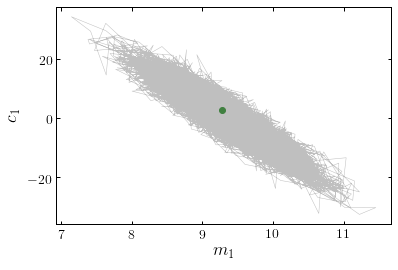

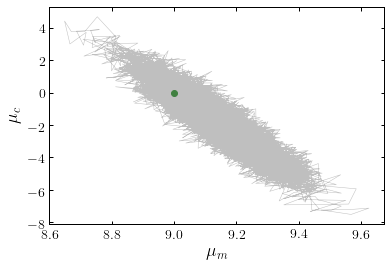

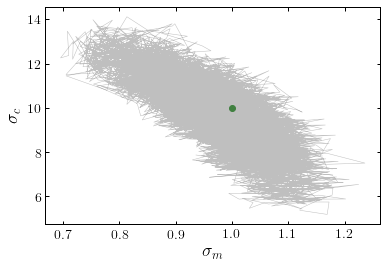

In [16]:
samples_burn = samples[:, 1000:]

plt.figure()
plt.plot(samples_burn[4,:], samples_burn[504,:], color="gray", alpha=0.5, lw=0.5)
plt.scatter(grads[0], ints[0], color="green")
plt.xlabel("$m_1$")
plt.ylabel("$c_1$")
plt.show()

plt.figure()
plt.plot(samples_burn[0,:], samples_burn[1,:], color="gray", alpha=0.5, lw=0.5)
plt.scatter(9., 0., color="green")
plt.xlabel("$\mu_m$")
plt.ylabel("$\mu_c$")
plt.show()

plt.figure()
plt.plot(samples_burn[2,:], samples_burn[3,:], color="gray", alpha=0.5, lw=0.5)
plt.scatter(1., 10., color="green")
plt.xlabel("$\sigma_m$")
plt.ylabel("$\sigma_c$")
plt.show()

Let's take another look at the individual object minimum reduced chi-squared fits from earlier and compare them to our posterior median fits for each object from our hierarchical model.

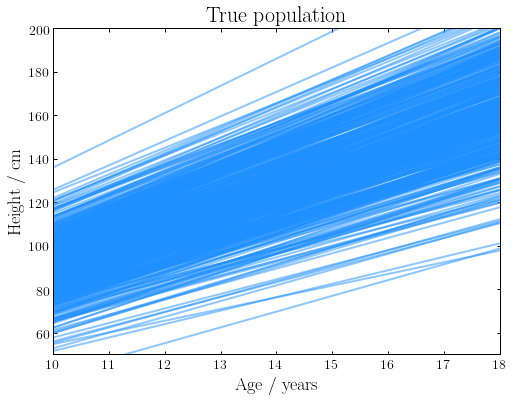

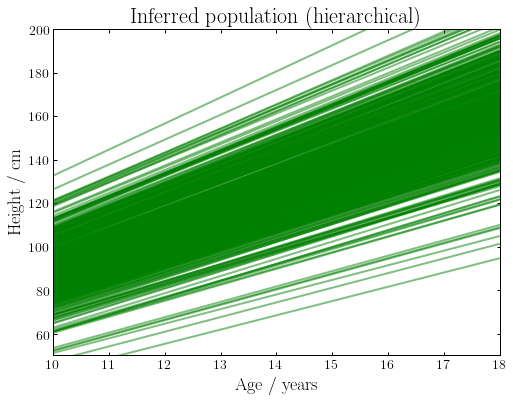

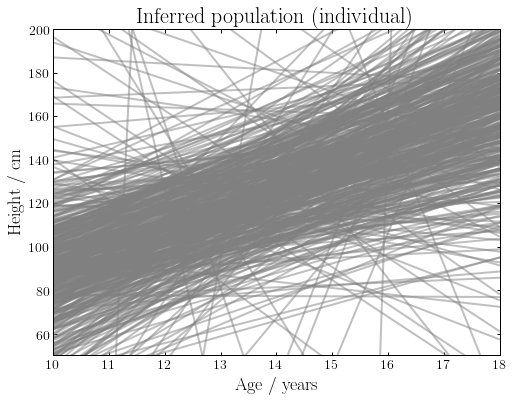

In [21]:
fig = plt.figure(figsize=(8, 6))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
plt.title("$\\mathrm{True\\ population}$", fontsize=22)

for i in range(500):
    data = population[i]
    plt.plot(x, grads[i]*x + ints[i], color="dodgerblue", alpha=0.5)

plt.show()


plt.figure(figsize=(8, 6))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
plt.title("$\\mathrm{Inferred\\ population\\ (hierarchical)}$", fontsize=22)

for i in range(500):
    data = population[i]
    plt.plot(x, np.median(samples_burn[4+i, :])*x + np.median(samples_burn[504+i, :]), color="green", alpha=0.5)

plt.show()


plt.figure(figsize=(8, 6))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
plt.title("$\\mathrm{Inferred\\ population\\ (individual)}$", fontsize=22)

for i in range(500):
    data = population[i]
    param = np.polyfit(data[:,0], data[:,1], 1, w=1/data[:,2])
    plt.plot(x, param[0]*x + param[1], color="gray", alpha=0.5)

plt.show()


Finally, let's look at the distribution of $m_j$ and $c_j$ in the population in each case and compare them to the inputs.

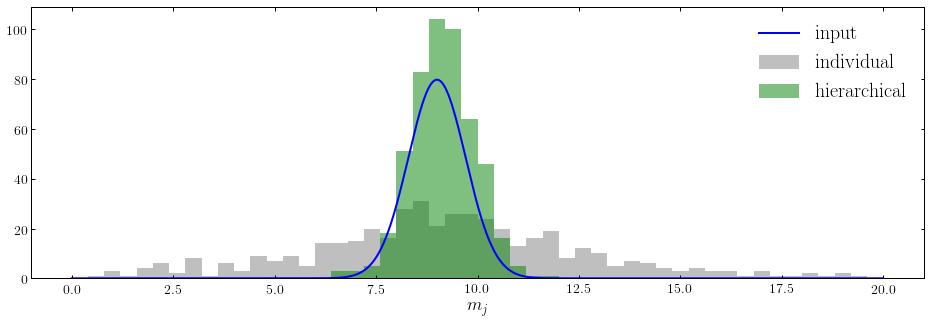

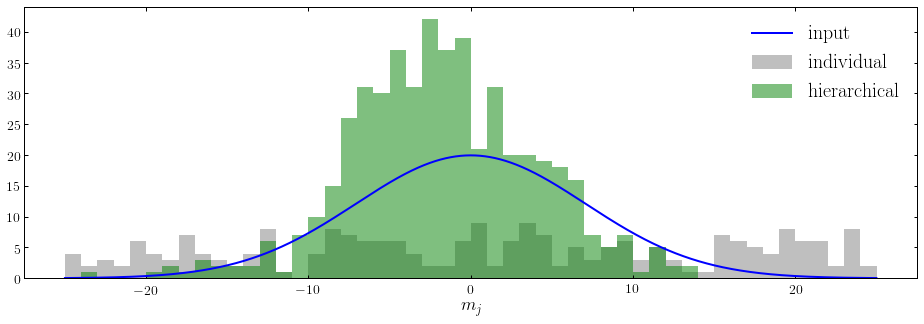

In [55]:
chisq_param = np.zeros((500, 2))

for i in range(500):
    data = population[i]
    param = np.polyfit(data[:, 0], data[:, 1], 1, w=1/data[:, 2])
    chisq_param[i, :] = param
    
plt.figure(figsize=(16, 5))
plt.hist(chisq_param[:,0], bins=50, range=(0, 20), color="gray", alpha=0.5, label="$\mathrm{individual}$")

plt.hist(np.median(samples_burn[4:504, :], axis=1), bins=50, range=(0, 20), color="green", alpha=0.5,
         label="$\mathrm{hierarchical}$")

x = np.arange(0, 20, 0.01)
plt.plot(x, 500*20/50*(1/np.sqrt(2*np.pi*1**2))*np.exp(-(x - 9.)**2/(1.)**2),
         color="blue", lw=2, zorder=10, label="$\mathrm{input}$")

plt.legend(frameon=False, fontsize=20)
plt.xlabel("$m_j$")
plt.show()


plt.figure(figsize=(16, 5))
plt.hist(chisq_param[:,1], bins=50, range=(-25, 25), color="gray", alpha=0.5, label="$\mathrm{individual}$")

plt.hist(np.median(samples_burn[504:, :], axis=1), bins=50, range=(-25, 25),
         color="green", alpha=0.5, label="$\mathrm{hierarchical}$")

x = np.arange(-25, 25, 0.01)
plt.plot(x, 500*(1/np.sqrt(2*np.pi*10**2))*np.exp(-(x - 0.)**2/(10.)**2),
         color="blue", lw=2, zorder=10, label="$\mathrm{input}$")

plt.legend(frameon=False, fontsize=20)
plt.xlabel("$m_j$")
plt.show()


In all cases a far more reliable recovery of the input distributions can be seen when applying our Bayesian hierarchical modelling approach.